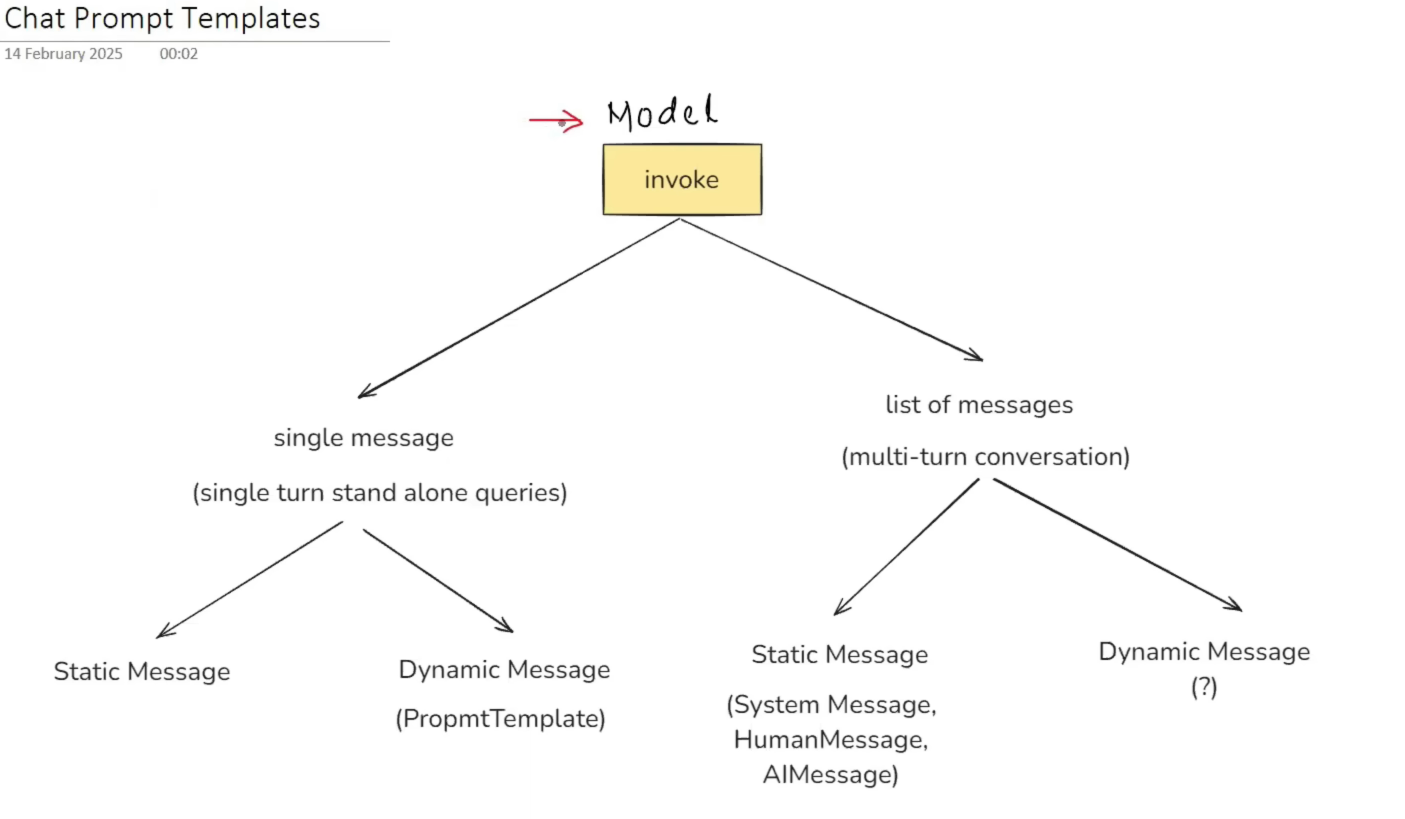


---

## Summarizing Prompts in LangChain: Step Flow and Implementation

Prompts are fundamentally the messages you send to a Large Language Model (LLM) when interacting with it. The LLM's output is highly dependent on the quality and structure of the prompt; even small changes can significantly alter the response. LangChain provides tools to manage and structure these prompts effectively.

### Step 1: Understanding LLM Temperature (Context Setting)

Before diving into prompt structure, it's crucial to understand the **Temperature** parameter, which controls the determinism and creativity of the LLM output.

| Temperature Value | Output Characteristics | Use Case |
| :--- | :--- | :--- |
| **Zero (or near zero)** | Output is highly deterministic (same input yields the same output every time). | Applications requiring consistency (e.g., factual queries, formal summaries). |
| **High (e.g., 1.5 to 2.0)** | Output is creative and varies significantly with the same input. | Applications requiring variety (e.g., generating creative content, poetry). |

**Example of Setting Temperature in Python (Illustrative Concept):**
When invoking the model, the temperature parameter controls creativity.

```python
# Assuming 'model' is an initialized LLM object
# Low temperature for deterministic output
model.invoke("Right a five line poem on cricket", temperature=0)
```

### Step 2: Static Prompts vs. Dynamic Prompts

LangChain helps shift from static prompting (where the user provides the entire prompt) to dynamic prompting (where the application structures the prompt using user inputs).

| Type | Description | Problem |
| :--- | :--- | :--- |
| **Static Prompt** | The user writes the entire message and sends it directly to the LLM. | Leads to inconsistent user experience, high chances of "hallucination," and output sensitivity if the user makes slight changes or errors (e.g., misspelling a paper title). |
| **Dynamic Prompt** | A pre-defined template is created with placeholders, which are filled at runtime using controlled user inputs (e.g., dropdowns). | Ensures consistent output quality and better control over the LLM response characteristics (e.g., including mathematical details or analogies). |

### Step 3: Creating Dynamic Single-Turn Prompts with `PromptTemplate`

For single-turn, standalone queries (e.g., summarizing a paper), the `PromptTemplate` class is used to create dynamic prompts.

**Key Benefits of `PromptTemplate` over standard F-strings:**

1.  **Validation:** Automatically validates that all defined placeholders in the template are provided in the input variables, preventing runtime errors.
2.  **Reusability:** Templates can be saved to a JSON file and loaded as needed, making the template reusable across a large application.
3.  **Ecosystem Integration:** Works seamlessly with other LangChain concepts, such as **Chains**, allowing the templating step and model invocation to be tied together and called with a single `.invoke()` command.

**Code Flow for `PromptTemplate` (Simplified):**

```python
from langchain_core.prompts import PromptTemplate
# Step 1: Define the template structure with placeholders {paper_input}, {style_input}, {length_input}
template_string = """Please summarize the research paper titled {paper_input}
                    with the following specifications: style: {style_input} and length: {length_input}...
                    (rest of fixed instructions)"""

# Step 2: Create the PromptTemplate object
template = PromptTemplate(
    template=template_string,
    input_variables=["paper_input", "style_input", "length_input"]
)

# Step 3: Fill the placeholders and generate the final prompt
final_prompt = template.invoke({
    "paper_input": "Attention Is All You Need",
    "style_input": "code heavy",
    "length_input": "Medium"
})

# Step 4: Invoke the Model with the generated prompt
# result = model.invoke(final_prompt)
```

### Step 4: Handling Multi-Turn Conversations and Context

To build a chatbot, the LLM must remember past interactions (maintain **context**), as simply sending the latest message results in the LLM forgetting the conversation history. The solution is to maintain a `chat_history` (a list of messages) and send the entire list with every new user query.

For proper context handling, messages should be labeled to indicate whether they came from the user or the AI. LangChain uses three specialized Message Types:

1.  **System Message:** Used at the beginning of the conversation to assign a role or specific instructions to the AI (e.g., "You are a helpful assistant").
2.  **Human Message:** The input provided by the user.
3.  **AI Message:** The response returned by the LLM.

**Code Flow for Context-Aware Chatbot:**

```python
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

# Step 1: Initialize chat history with a system message
chat_history = [
    SystemMessage(content="You are a helpful AI Assistant")
]

# Step 2: Inside the conversation loop, wrap the user's message
user_input = input("User: ")
chat_history.append(HumanMessage(content=user_input)) # Label user input

# Step 3: Invoke the model with the entire history
result = model.invoke(chat_history)

# Step 4: Convert the result into an AI Message and append it to the history
chat_history.append(AIMessage(content=result.content)) # Label AI output

# This ensures the LLM has all previous messages (context) for subsequent calls.
```

### Step 5: Creating Dynamic Multi-Turn Prompts with `ChatPromptTemplate`

When creating a dynamic conversation flow where the list of messages itself needs placeholders (e.g., a system message where the "domain expert" changes dynamically), the `ChatPromptTemplate` is used.

**Code Flow for `ChatPromptTemplate`:**

```python
from langchain_core.prompts import ChatPromptTemplate

# Note: ChatPromptTemplate expects messages defined as tuples (role, content)
chat_template = ChatPromptTemplate.from_messages([
    # System message is dynamic, filling the {domain} placeholder
    ("system", "You are a helpful {domain} expert."),
    # Human message is dynamic, filling the {topic} placeholder
    ("human", "Explain in simple terms what is {topic}.")
])

# Invoke the template to fill the placeholders
final_prompt = chat_template.invoke({
    "domain": "Cricket",
    "topic": "दूसरा"
})

# final_prompt will contain a list of structured messages ready for LLM invocation.
```

### Step 6: Using `MessagePlaceholder` for External History Retrieval

A `MessagePlaceholder` is a special placeholder used inside a `ChatPromptTemplate` to dynamically insert an entire list of messages (chat history) at runtime. This is critical for scenarios where previous conversation history needs to be retrieved from an external database and included in the current prompt context.

**Code Flow for `MessagePlaceholder`:**

```python
from langchain_core.prompts import ChatPromptTemplate, MessagePlaceholder

# Step 1: Define the chat template structure
chat_template = ChatPromptTemplate.from_messages([
    # Standard System Message
    ("system", "You are a helpful customer support agent."),
    
    # Placeholder for previous conversation history
    MessagePlaceholder(variable_name="chat_history"),
    
    # Current Human Query (dynamic)
    ("human", "{query}")
])

# Step 2: Load the previous chat history (simulated fetch from database)
# chat_history_loaded = [HumanMessage(content=...), AIMessage(content=...), ...]

# Step 3: Invoke the template, inserting the loaded history into the placeholder
final_prompt = chat_template.invoke({
    "chat_history": chat_history_loaded,
    "query": "Where is my refund?"
})

# The final prompt will be a list containing the System Message, followed by all messages
# from 'chat_history_loaded', followed by the current 'query'.
```


***

## Step 1: Conceptual Code for LLM Temperature Control

Temperature is a crucial parameter that determines the creativity and determinism of the LLM output. A temperature of 0 (or near zero) ensures the same input always yields the same output (deterministic), while a higher temperature (e.g., 1.5 to 2.0) yields creative and varied outputs.

**File: `temperature_concept.py`**
*(Note: This is conceptual code to illustrate the parameter setting discussed in the source)*

```python
# Setup imports (assuming necessary configuration like loading API keys is done)
from langchain_openai import ChatOpenAI

# Load environment variables (not shown, but assumed setup)
# load_dotenv()

# Initialize the model
# In a real application, temperature is set here or passed during the .invoke() call.

# Scenario A: Deterministic output (e.g., factual query)
# model_low_temp = ChatOpenAI(temperature=0)
# result_low = model_low_temp.invoke("Right a five line poem on cricket")
# print(f"Result 1 (Temp 0): {result_low.content}")

# Scenario B: Creative output (e.g., creative writing)
# model_high_temp = ChatOpenAI(temperature=1.5)
# result_high = model_high_temp.invoke("Right a five line poem on cricket")
# print(f"Result 2 (Temp 1.5): {result_high.content}")

# Output explanation (as described in sources):
# Running Scenario A multiple times would produce the same poem every time.
# Running Scenario B multiple times would produce different, creative poems.
```

## Step 2: Creating a Static Prompt Application UI

This demonstrates the basic structure of an LLM application, where the user provides the entire prompt (a **static prompt**), which is then sent directly to the LLM.

**File: `prompt_ui_static.py`**
*(Requires `pip install streamlit langchain-openai`)*

```python
# Import necessary libraries
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import streamlit as st

# Load environment variables (assumes .env file with OPENAI_API_KEY)
load_dotenv()

# Initialize the Chat Model
model = ChatOpenAI()

# --- Streamlit UI Setup ---
st.header("Research Tool") #

# User Input Box
user_input = st.text_input("Enter your prompt", key="user_prompt") #

# Summarize Button Logic
if st.button("Summarize"): #
    if user_input:
        # Step 1: The user input is the static prompt itself
        
        # Step 2: Invoke the model with the static prompt
        result = model.invoke(user_input)
        
        # Step 3: Display the result
        st.write(result.content) #
    else:
        st.write("Please enter a prompt.")

# To Run: streamlit run prompt_ui_static.py
# Example User Input: "Summarize the Attention Is All You Need paper in simple fashion"
```

## Step 3: Implementing Dynamic Prompts with `PromptTemplate`

This converts the static approach into a **dynamic prompt** using a structured template. This ensures a **consistent user experience** and prevents the LLM from relying entirely on user-written, potentially sensitive or erroneous, free-form text.

**File: `prompt_ui_dynamic.py`**
*(Modification of the file from Step 2)*

```python
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import streamlit as st
from langchain_core.prompts import PromptTemplate # New Import

load_dotenv()
model = ChatOpenAI()

# --- Dynamic Prompt Template Definition ---
template_string = """
Please summarize the research paper titled {paper_input}
with the following specifications: style: {style_input} and length: {length_input}.
The summary must include relevant mathematical equations if present in the paper,
explain mathematical concepts using simple intuitive code snippets where applicable,
and add relatable analogies. If information is unavailable, put 'Insufficient information available'
instead of hallucinating.
Ensure the summary is clear, accurate, and aligned with the provided style and length.
"""

template = PromptTemplate(
    template=template_string,
    input_variables=["paper_input", "style_input", "length_input"] #
    # Optional: validate_template=True for validation checks
)

# --- Streamlit UI Setup (Now using select boxes for controlled input) ---
st.header("Research Tool (Dynamic)")

# Dynamic Inputs (Select Boxes/Drop Downs)
paper_input = st.selectbox("Select Research Paper:",
                           options=['Attention Is All You Need', 'Word2Vec', 'GPT-3'])
style_input = st.selectbox("Select Explanation Style:",
                           options=['Simple', 'Maths heavy', 'Code heavy'])
length_input = st.selectbox("Select Explanation Length:",
                            options=['Short', 'Medium', 'Long'])

if st.button("Summarize"):
    
    # Step 1: Fill the placeholders using the user inputs
    final_prompt = template.invoke({
        "paper_input": paper_input,
        "style_input": style_input,
        "length_input": length_input
    })

    # Step 2: Invoke the model with the generated dynamic prompt
    result = model.invoke(final_prompt)
    
    # Step 3: Display the result
    st.write(result.content)

# To Run: streamlit run prompt_ui_dynamic.py
```

## Step 4: Template Reusability and Loading

`PromptTemplate` allows templates to be saved as JSON files for **reusability** across different parts of a large application, avoiding code bulkiness.

### 4a. Generating the Template JSON

**File: `prompt_generator.py`**

```python
from langchain_core.prompts import PromptTemplate
# Import load_prompt function (will be needed in 4b)
from langchain.prompts import load_prompt #
# Note: For simplicity, using the template definition from Step 3
# In a real scenario, template_string should be defined or loaded here

template_string = """... (Template string content from Step 3) ..."""

# 1. Create the template object
template = PromptTemplate(
    template=template_string,
    input_variables=["paper_input", "style_input", "length_input"]
)

# 2. Save the template to a JSON file
template.save(file_path="template.json")

print("Template saved to template.json")

# To Run: python prompt_generator.py (Creates template.json)
```

### 4b. Loading the Template

**File: `prompt_ui_reusable.py`**
*(Modification to load the template instead of defining it inline)*

```python
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import streamlit as st
from langchain.prompts import load_prompt # Important: Use 'langchain.prompts' for loading

load_dotenv()
model = ChatOpenAI()

# --- Template Loading ---
# 1. Load the template from the JSON file
template = load_prompt("template.json")

# --- Streamlit UI Setup (Inputs remain the same as Step 3) ---
# ... (paper_input, style_input, length_input definitions) ...

if st.button("Summarize"):
    # 2. Invoke the loaded template
    final_prompt = template.invoke({
        "paper_input": paper_input,
        "style_input": style_input,
        "length_input": length_input
    })
    result = model.invoke(final_prompt)
    st.write(result.content)
```

## Step 5: Basic Context-Aware Chatbot (Multi-Turn Conversation)

A basic chatbot requires maintaining conversation **context** so the LLM remembers previous messages. This is done by sending the entire `chat_history` (a list of messages) with every new user input.

**File: `chatbot_basic.py`**

```python
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

load_dotenv()
model = ChatOpenAI()

# Initialize an empty list to store conversation history (context)
chat_history = []

print("--- Simple Chatbot (Type 'exit' to quit) ---")

while True: # Infinite loop for continuous conversation
    # 1. Get user input
    user_input = input("User: ")

    # 2. Check for exit condition
    if user_input.lower() == 'exit':
        break
    
    # 3. Append the new user input to the history
    chat_history.append(user_input)
    
    # 4. Invoke the model with the entire list of messages (chat_history)
    # The .invoke() function is flexible enough to handle a list of messages
    try:
        result = model.invoke(chat_history)
        
        # 5. Append the AI's response to the history
        # Note: We append the content string here, not the full result object
        chat_history.append(result.content)
        
        # 6. Display the AI response
        print(f"AI: {result.content}")
        
    except Exception as e:
        print(f"An error occurred: {e}")
        # If invocation fails, remove the last user message to clean history
        chat_history.pop()

print("\nFull Conversation History:")
print(chat_history) #

# To Run: python chatbot_basic.py
# Problem in this version: The history is unlabeled, making it hard for the LLM to differentiate
# who said what over a long conversation.
```

## Step 6: Integrating Labeled Messages for Context

To fix the labeling problem from Step 5, LangChain provides specific message classes: **System Message** (setting the AI's role), **Human Message** (user input), and **AI Message** (model output).

**File: `chatbot_labeled.py`**

```python
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
# Import specific message types
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

load_dotenv()
model = ChatOpenAI()

# Initialize chat history with the System Message (setting the AI's role)
chat_history = [
    SystemMessage(content="You are a helpful AI Assistant")
]

print("--- Context-Aware Chatbot (Type 'exit' to quit) ---")

while True:
    user_input = input("User: ")

    if user_input.lower() == 'exit':
        break
    
    # 1. Append the user input as a labeled Human Message
    new_human_message = HumanMessage(content=user_input)
    chat_history.append(new_human_message)
    
    # 2. Invoke the model with the entire labeled history
    result = model.invoke(chat_history)
    
    # 3. Convert the result to a labeled AI Message and append it
    new_ai_message = AIMessage(content=result.content)
    chat_history.append(new_ai_message)
    
    # 4. Display the AI response
    print(f"AI: {result.content}")
    
# Print the structured history upon exit
print("\nStructured Conversation History:")
for message in chat_history:
    print(f"[{type(message).__name__}]: {message.content}")

# To Run: python chatbot_labeled.py
# Advantage: The LLM now knows the context of every turn.
```

## Step 7: Creating Dynamic Multi-Turn Prompts with `ChatPromptTemplate`

When you need to dynamically inject variables (like an "expert domain") into the list of messages in a multi-turn conversation, you use `ChatPromptTemplate`. Unlike `PromptTemplate`, it requires messages to be defined as **tuples** of `(role, content_string)` containing placeholders.

**File: `chat_prompt_template.py`**

```python
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage # Required for type hinting/understanding, though tuples are used in template definition

# --- Define the Dynamic Chat Template ---
# Use ChatPromptTemplate.from_messages and define messages as (role, content string) tuples
chat_template = ChatPromptTemplate.from_messages([
    # Dynamic System Message: {domain} is a placeholder
    ("system", "You are a helpful {domain} expert."),
    
    # Dynamic Human Message: {topic} is a placeholder
    ("human", "Explain in simple terms what is {topic}.")
])

# 1. Invoke the template to fill the placeholders
final_prompt = chat_template.invoke({
    "domain": "Cricket", # Fills {domain}
    "topic": "दूसरा"      # Fills {topic}
})

# 2. Print the final structured prompt (list of messages)
print("--- Final Dynamic Chat Prompt ---")
print(final_prompt)

# To invoke the model (conceptual):
# result = model.invoke(final_prompt)

# To Run: python chat_prompt_template.py
```

## Step 8: Inserting External History using `MessagePlaceholder`

A `MessagePlaceholder` is a special component used within a `ChatPromptTemplate` to dynamically insert an entire list of messages (like retrieved chat history from a database) at a specific point in the conversation sequence.

### 8a. Setup: External History File

First, we simulate retrieving past customer history from a file.

**File: `chat_history.txt`**
*(This file should exist in the same directory)*

```text
HumanMessage(content='I want to request a refund for my order 12345')
AIMessage(content='Your refund request for order 12345 has been initiated. You will receive it in 3 to 5 business days.')
```

### 8b. Implementation: Using the Placeholder

**File: `message_placeholder.py`**

```python
from langchain_core.prompts import ChatPromptTemplate, MessagePlaceholder
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage # Used for defining history

# --- 1. Load the Chat History from file ---
loaded_history = []
# Simulate loading the history (requires defining message objects based on file content)
# For simplicity, we manually define the objects as they would be loaded from a structured database:
chat_history_loaded = [
    HumanMessage(content='I want to request a refund for my order 12345'),
    AIMessage(content='Your refund request for order 12345 has been initiated. You will receive it in 3 to 5 business days.')
]

# --- 2. Define the Chat Template using the Placeholder ---
chat_template = ChatPromptTemplate.from_messages([
    # Standard instruction message
    ("system", "You are a helpful customer support agent."),
    
    # Placeholder: All messages passed to the 'chat_history' variable will be inserted here
    MessagePlaceholder(variable_name="chat_history"),
    
    # The current query from the user (dynamic placeholder)
    ("human", "{query}")
])

# --- 3. Invoke the template, inserting the loaded history ---
current_query = "Where is my refund?" # The user's new question

final_prompt = chat_template.invoke({
    # Pass the retrieved list of messages into the placeholder variable
    "chat_history": chat_history_loaded,
    # Pass the current query into the query variable
    "query": current_query
})

# 4. Print the final message list sent to the LLM
print("--- Final Prompt List (Including History) ---")
for message in final_prompt:
    print(f"[{type(message).__name__}]: {message.content}")

# To Run: python message_placeholder.py
# Result: The final list contains the System Message, followed by the two historical messages,
# followed by the current Human Query.
```

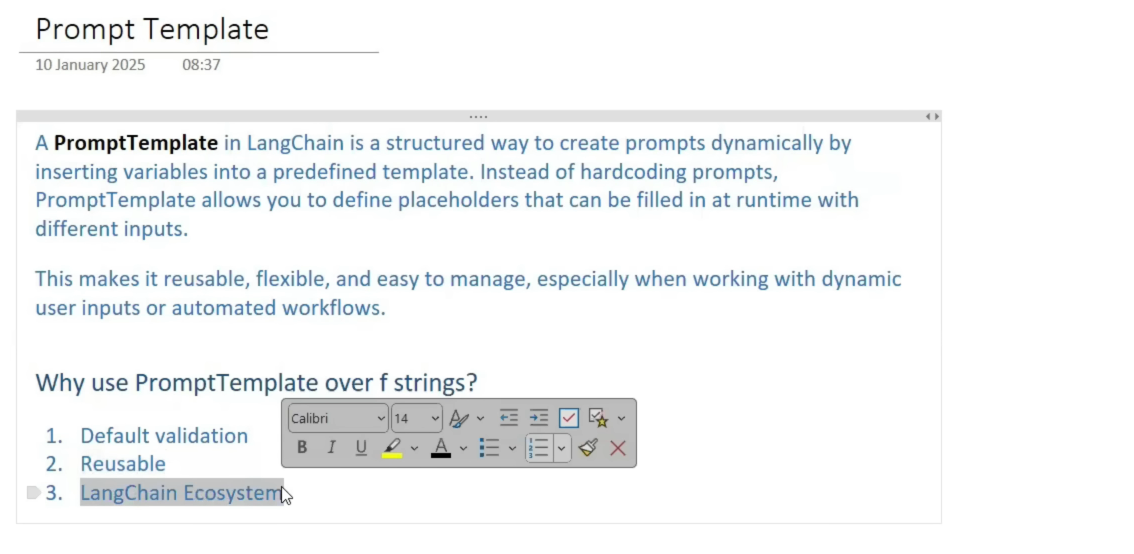

The solutions suggested in the sources to address the problems faced when building robust LLM applications using LangChain are listed below in a minimalist format.

| Problem Addressed | Solution Suggested (Tools/Techniques) |
| :--- | :--- |
| **I. Uncontrolled/Inconsistent LLM Output** (Due to user writing the entire prompt, or potential hallucination) | **Dynamic Prompts using `PromptTemplate`:** Create a fixed, detailed template containing specific instructions and **placeholders** that are filled using controlled user inputs (e.g., dropdowns), ensuring consistent output quality regardless of user phrasing. |
| **II. Lack of Prompt Validation** (Risk of runtime error if placeholders are missing) | **Built-in Template Validation:** Use the **`PromptTemplate`** class, which includes automatic validation checks to ensure that all required input variables are correctly supplied for the placeholders. |
| **III. Code Bulkiness and Reusability** (Large templates cluttering main code) | **Template Reusability:** Save prompt templates externally as a **JSON file** using the `save` function, allowing them to be loaded and reused across different components of a large application. |
| **IV. Integrating Prompts into the LLM Pipeline** (Two separate `.invoke()` calls) | **Chain Integration:** Utilize the tight coupling of `PromptTemplate` with the LangChain ecosystem to combine the templating step and the model invocation into a single **Chain**, reducing calls and simplifying the process. |
| **V. Loss of Conversation Context** (LLM forgetting previous turns in a chat) | **Maintain Complete Chat History:** Store all messages in a **`chat_history` list** and send the entire list to the LLM during every subsequent invocation. |
| **VI. Unlabeled Message History** (LLM cannot distinguish between Human and AI messages) | **Labeled Message Classes:** Use specific message classes (`SystemMessage`, `HumanMessage`, `AIMessage`) to label the sender's role for every item in the chat history, improving LLM understanding and context maintenance. |
| **VII. Dynamic Variables in Multi-Turn Prompts** (E.g., dynamically setting the AI's role) | **`ChatPromptTemplate`:** Use this template class specifically for scenarios involving a list of messages where individual messages (like the `SystemMessage` or `HumanMessage`) contain dynamic placeholders. (Note: It requires a special tuple syntax `(role, content_string)` instead of the standard message classes). |
| **VIII. Inserting External History** (Retrieving past chat logs for context) | **`MessagePlaceholder`:** Insert this special placeholder inside a `ChatPromptTemplate` to dynamically inject an entire list of external messages (like retrieved chat history) at a specific point in the prompt sequence. |
| **IX. Conceptual Error in Temperature Explanation** (Initial confusion about deterministic vs. creative output) | **Rectification of Temperature Usage:** Ensure that **Temperature 0** is used for applications requiring **deterministic** (same input, same output) results, while a higher temperature (e.g., 1.5) is used for **creative and varied** output. |

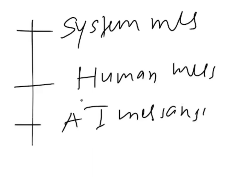



| Message Type | Sender/Source | Primary Purpose |
| :--- | :--- | :--- |
| **System Message** | System/Application | Sets the **role, persona, or constraints** for the AI, sent at the beginning of the conversation. (E.g., "You are a helpful assistant" or "You are a very knowledgeable doctor"). |
| **Human Message** | User (Human) | The **input query** or message provided by the user to the LLM. (E.g., "Tell me the capital of India"). |
| **AI Message** | LLM/AI | The **response** generated by the LLM and returned to the user. (E.g., "The capital of India is New Delhi"). |

Using these messages ensures that every entry in the `chat_history` is **labeled**, allowing the LLM to understand who said what, even as the conversation grows.

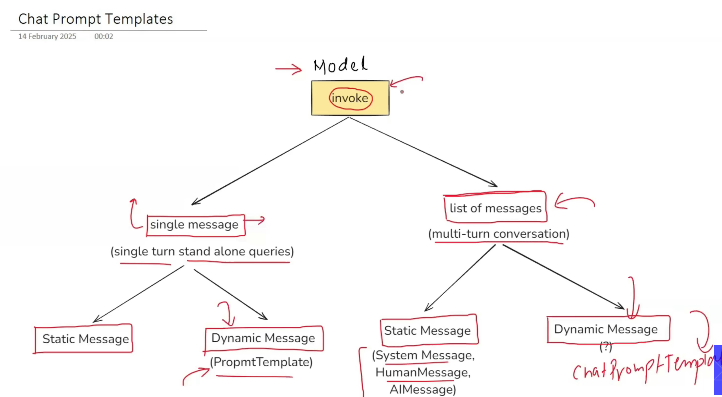

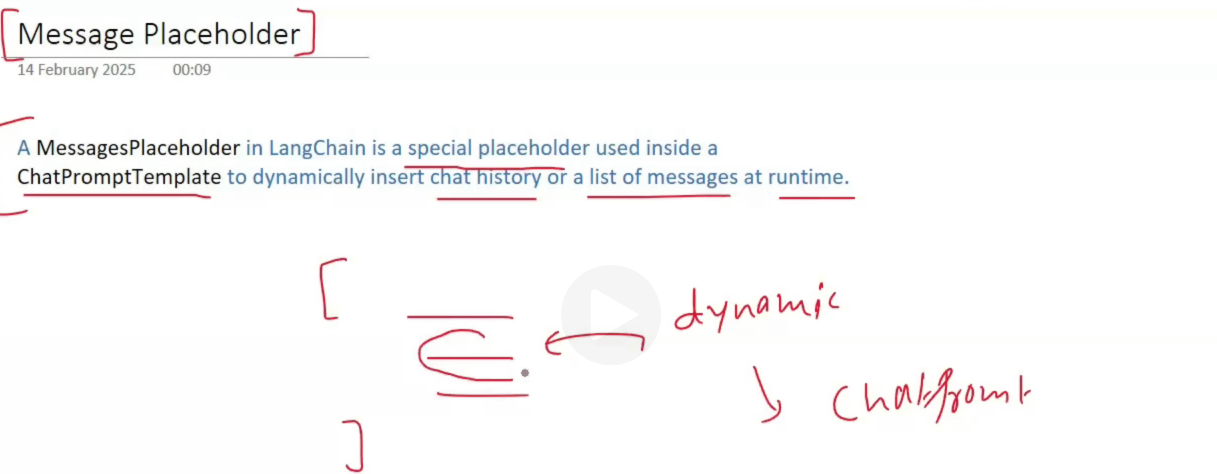

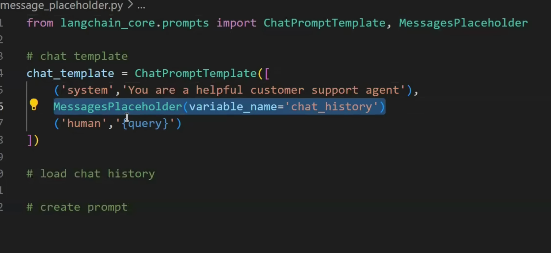